In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import seaborn as sns
from typing import Dict, List, Optional, Tuple, Union
import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from utils_activations import rot13_alpha, LlamaActivationExtractor

In [2]:
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'

In [3]:
# person = "Alexander Hamilton"
# reasoning_question  = "What is the capital of the state that the first U.S. secretary of the treasury died in?"

In [4]:
person = "Hillary Clinton"
reasoning_question = "What is the capital of the state that the secretary of state of the U.S. in 2009 was born in?"

# Load model and extractor

In [5]:
activation_extractor = LlamaActivationExtractor(
    model_name_or_path=path,
    layer_defaults='even'
    )

Using device: cuda


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
activation_extractor.overwrite_chat_template()

# Get response

In [7]:
formatted = activation_extractor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': reasoning_question}],
    tokenize=False,
    add_generation_prompt=True,
)
generation_results = activation_extractor.generate_with_activations(
    formatted,
    do_sample=False,
    max_new_tokens=1000,
    temperature=0.0,
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


# Token alignment helper function

In [8]:
def align_tokens(short_tokens, long_tokens):
    """
    Align two different tokenizations of the same text.
    
    Args:
        short_tokens: List of tokens from fine-grained tokenization
        long_tokens: List of tokens from coarse-grained tokenization
    
    Returns:
        alignment: List where alignment[i] gives the long_token index 
                  that short_tokens[i] belongs to
    """
    # Reconstruct the original text to verify consistency
    short_text = ''.join(short_tokens)
    long_text = ''.join(long_tokens)
    
    if short_text != long_text:
        raise ValueError("Token sequences don't represent the same text")
    
    alignment = []
    short_pos = 0  # Character position in short tokenization
    long_pos = 0   # Character position in long tokenization
    long_idx = 0   # Current index in long_tokens
    
    for short_idx, short_token in enumerate(short_tokens):
        # Find which long token this short token belongs to
        while long_idx < len(long_tokens):
            long_token = long_tokens[long_idx]
            
            # Check if current short token fits within current long token
            if (short_pos >= long_pos and 
                short_pos + len(short_token) <= long_pos + len(long_token)):
                alignment.append(long_idx)
                break
            else:
                # Move to next long token
                long_pos += len(long_tokens[long_idx])
                long_idx += 1
        else:
            raise ValueError(f"Could not align short token {short_idx}: '{short_token}'")
        
        short_pos += len(short_token)
    
    return alignment

def get_alignment_mapping(short_tokens, long_tokens):
    """
    Get a more detailed alignment mapping showing which short tokens 
    correspond to each long token.
    
    Returns:
        dict: {long_token_index: [list_of_short_token_indices]}
    """
    alignment = align_tokens(short_tokens, long_tokens)
    
    mapping = {}
    for short_idx, long_idx in enumerate(alignment):
        if long_idx not in mapping:
            mapping[long_idx] = []
        mapping[long_idx].append(short_idx)
    
    return mapping

In [9]:
encoded = activation_extractor.tokenizer.encode(rot13_alpha(generation_results['response']))
english_tokens = [activation_extractor.tokenizer.decode(e) for e in encoded]

In [10]:
end_think_idx = np.argwhere(np.array(generation_results['response_tokens']) == "</think>")
if end_think_idx.size != 0:
    end_think_idx = end_think_idx.item()
else:
    end_think_idx = len(generation_results['response_tokens'])
response_tokens = generation_results['response_tokens'][:end_think_idx]
merged_response = ''.join(response_tokens)
translated_response_tokens = [rot13_alpha(t) for t in response_tokens]

english_token_ids = activation_extractor.tokenizer.encode(rot13_alpha(merged_response), add_special_tokens=False)
english_tokens = [activation_extractor.tokenizer.decode(e) for e in english_token_ids]


In [11]:
word_start_idxs = [idx for idx, token in enumerate(translated_response_tokens) if token.startswith(' ')]

In [12]:
token_alignments = align_tokens(translated_response_tokens, english_tokens)

# Logit Lens Helper Functions

In [15]:

def logit_lens_single_layer(self, 
                           activation: torch.Tensor, 
                           apply_layer_norm: bool = True) -> torch.Tensor:
    """
    Apply logit lens to a single layer's activations.
    
    Args:
        activation: Tensor of shape (seq_len, hidden_dim) or (batch, seq_len, hidden_dim)
        apply_layer_norm: Whether to apply layer normalization before projection
        
    Returns:
        Logits tensor of shape (seq_len, vocab_size) or (batch, seq_len, vocab_size)
    """
    # Ensure activation is on the correct device
    activation = activation.to(self.device)
    
    # Apply layer normalization if requested (this is typically done in the final layer)
    if apply_layer_norm:
        activation = self.model.model.norm(activation)
    
    # Project to vocabulary space
    logits = self.model.lm_head(activation)

    return logits

def logit_lens_analysis(self, 
                       activations: Dict[str, torch.Tensor],
                       apply_layer_norm: bool = True,
                       top_k: int = 10) -> Dict[str, Dict]:
    """
    Perform logit lens analysis on extracted activations.
    
    Args:
        activations: Dictionary of layer activations
        apply_layer_norm: Whether to apply layer normalization before projection
        top_k: Number of top predictions to return for each position
        
    Returns:
        Dictionary containing logit lens results for each layer
    """
    results = {}
    
    for layer_name, activation in activations.items():
        # Get logits for this layer
        logits = logit_lens_single_layer(self, activation, apply_layer_norm)
        
        # Get probabilities
        probs = F.softmax(logits, dim=-1)
        
        # Get top-k predictions for each position
        top_k_probs, top_k_indices = torch.topk(probs, top_k, dim=-1)
        
        # Convert to tokens
        seq_len = logits.shape[-2]
        position_predictions = []
        
        for pos in range(seq_len):
            pos_top_k_indices = top_k_indices[pos] if logits.dim() == 2 else top_k_indices[0, pos]
            pos_top_k_probs = top_k_probs[pos] if logits.dim() == 2 else top_k_probs[0, pos]
            
            predictions = []
            for i in range(top_k):
                token_id = pos_top_k_indices[i].item()
                prob = pos_top_k_probs[i].item()
                token = self.tokenizer.decode([token_id])
                predictions.append({
                    'token': token,
                    'token_id': token_id,
                    'probability': prob
                })
            
            position_predictions.append(predictions)
        
        results[layer_name] = {
            'logits': logits.cpu(),
            'probabilities': probs.cpu(),
            'top_k_predictions': position_predictions
        }
    
    return results

def compare_logit_lens_predictions(self, 
                                 logit_lens_results: Dict[str, Dict],
                                 actual_tokens: List[str],
                                 position: int = -1) -> Dict:
    """
    Compare logit lens predictions across layers for a specific position.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        actual_tokens: List of actual tokens generated
        position: Position to analyze (-1 for last position)
        
    Returns:
        Dictionary comparing predictions across layers
    """
    if position == -1:
        position = len(actual_tokens) - 1
    
    comparison = {
        'position': position,
        'actual_token': actual_tokens[position] if position < len(actual_tokens) else None,
        'layer_predictions': {}
    }
    
    for layer_name, results in logit_lens_results.items():
        if position < len(results['top_k_predictions']):
            comparison['layer_predictions'][layer_name] = results['top_k_predictions'][position]
    
    return comparison

def get_logit_lens_evolution(self, 
                                 logit_lens_results: Dict[str, Dict],
                                 target_token: str,
                                 position: int = -1,
                                 ) -> plt.Figure:
    """
    Visualize how the probability of a target token evolves across layers.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        target_token: Token to track across layers
        position: Position to analyze (-1 for last position)
        figsize: Figure size for the plot
        
    Returns:
        matplotlib Figure object
    """
    # Extract layer numbers and probabilities
    layer_nums = []
    probabilities = []
    
    for layer_name, results in logit_lens_results.items():
        # Extract layer number from layer name (assumes format "layer_X")
        layer_num = int(layer_name.split('_')[-1])
        layer_nums.append(layer_num)
        
        # Find probability of target token at specified position
        if position == -1:
            position = len(results['top_k_predictions']) - 1
        
        target_prob = 0.0
        if position < len(results['top_k_predictions']):
            for pred in results['top_k_predictions'][position]:
                if pred['token'] == target_token:
                    target_prob = pred['probability']
                    break
        
        probabilities.append(target_prob)
    
    # Sort by layer number
    sorted_data = sorted(zip(layer_nums, probabilities))
    layer_nums, probabilities = zip(*sorted_data)
    return layer_nums, probabilities

def visualize_logit_lens_evolution(self, 
                                 logit_lens_results: Dict[str, Dict],
                                 target_token: str,
                                 position: int = -1,
                                 figsize: Tuple[int, int] = (12, 8)) -> plt.Figure:
    """
    Visualize how the probability of a target token evolves across layers.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        target_token: Token to track across layers
        position: Position to analyze (-1 for last position)
        figsize: Figure size for the plot
        
    Returns:
        matplotlib Figure object
    """
    # Extract layer numbers and probabilities
    layer_nums = []
    probabilities = []
    
    for layer_name, results in logit_lens_results.items():
        # Extract layer number from layer name (assumes format "layer_X")
        layer_num = int(layer_name.split('_')[-1])
        layer_nums.append(layer_num)
        
        # Find probability of target token at specified position
        if position == -1:
            position = len(results['top_k_predictions']) - 1
        
        target_prob = 0.0
        if position < len(results['top_k_predictions']):
            for pred in results['top_k_predictions'][position]:
                if pred['token'] == target_token:
                    target_prob = pred['probability']
                    break
        
        probabilities.append(target_prob)
    
    # Sort by layer number
    sorted_data = sorted(zip(layer_nums, probabilities))
    layer_nums, probabilities = zip(*sorted_data)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(layer_nums, probabilities, 'b-o', linewidth=2, markersize=6)
    ax.set_xlabel('Layer Number')
    ax.set_ylabel('Probability')
    ax.set_title(f'Probability Evolution of Token "{target_token}" at Position {position}')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(probabilities) * 1.1 if probabilities else 1)
    
    return fig

def analyze_prediction_confidence(self, 
                                logit_lens_results: Dict[str, Dict],
                                position: int = -1) -> Dict:
    """
    Analyze prediction confidence across layers using entropy and top-1 probability.
    
    Args:
        logit_lens_results: Results from logit_lens_analysis
        position: Position to analyze (-1 for last position)
        
    Returns:
        Dictionary with confidence metrics for each layer
    """
    confidence_metrics = {}
    
    for layer_name, results in logit_lens_results.items():
        if position == -1:
            pos = len(results['top_k_predictions']) - 1
        else:
            pos = position
        
        if pos < len(results['top_k_predictions']):
            # Get full probability distribution for this position
            probs = results['probabilities'][pos] if results['probabilities'].dim() == 2 else results['probabilities'][0, pos]
            
            # Calculate entropy (lower = more confident)
            entropy = -torch.sum(probs * torch.log(probs + 1e-10)).item()
            
            # Get top-1 probability
            top1_prob = results['top_k_predictions'][pos][0]['probability']
            
            # Get top-1 token
            top1_token = results['top_k_predictions'][pos][0]['token']
            
            confidence_metrics[layer_name] = {
                'entropy': entropy,
                'top1_probability': top1_prob,
                'top1_token': top1_token,
                'position': pos
            }
    
    return confidence_metrics

def get_layer_names(self) -> List[str]:
    """Get all available layer names in the model."""
    return [name for name, _ in self.model.named_modules()]

# Running Analysis

In [14]:
logit_lens_results = logit_lens_analysis(
    activation_extractor,
    generation_results['token_activations'],
    top_k=5
)

In [ ]:
results = {
    'prob': [],
    'layer': []
}
for word_start_idx in word_start_idxs:
    target_token = english_tokens[token_alignments[word_start_idx]]
    layers, probs = get_logit_lens_evolution(
        activation_extractor, 
        logit_lens_results,
        target_token=target_token,
        position=word_start_idx
    )
    results['prob'].extend(probs)
    results['layer'].extend(layers)

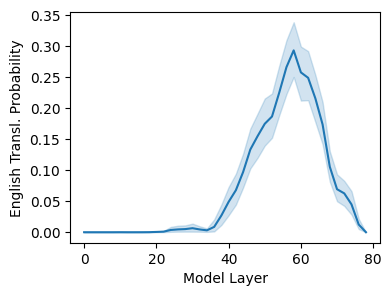

In [31]:
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(4, 3))
sns.lineplot(data=df, x='layer', y='prob', ax=ax)
plt.ylabel('English Transl. Probability')
plt.xlabel('Model Layer')
plt.show()